# Exporting LLM Runs and Feedback
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langsmith-cookbook/blob/main/exploratory-data-analysis/exporting-llm-runs-and-feedback/llm_run_etl.ipynb)

Understanding how your LLM app interacts with users is crucial. LangSmith offers a number of useful ways to interact with and annotate trace data directly in the app. You can also easily query that trace data so you can process it with your tool of choice.

This tutorial guides you through exporting LLM traces and associated feedback from LangSmith for further analysis. By the end, you'll be able to export a flat table of LLM run information that you can analyze, enrich, or use for model training.

Before we start, ensure you have a LangChain project with some logged traces. You can generate some using almost any of the other recipes in this cookbook. The overall steps will be:

1. Query runs, filtering by time, tags, or other attributes.
2. Add in associated feedback metrics (if captured)
3. Export to analysis tool.

To make things easy, we will be loading the data into a pandas dataframe. We will be doing the ETL on LLM runs logged from LangChain, but you can modify the code below to handle whatever schema is used by your deployed model. Now let's set up our environment!

#### Setup

First, install langsmith and pandas and set your langsmith API key to connect to your project.
We will also install LangChain to use one of its formatting utilities.

In [1]:
# %pip install -U langchain langsmith pandas seaborn --quiet

In [2]:
%env LANGCHAIN_API_KEY="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"
# %pip install --upgrade pandas

env: LANGCHAIN_API_KEY="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"


In [3]:
from langsmith import Client
import pandas as pd

client = Client()

## 1. Query Runs

Now that the environment is ready, we will load the run data from LangSmith. Let's try loading all our LLM runs from the past week. To do so, we will filter for runs with the "llm" `run_type` from the past week.

Please reference the [docs](https://docs.smith.langchain.com/tracing/faq/querying_traces) for guidance on more complex filters (using metadata, tags, and other attributes).


In [4]:
from datetime import datetime, timedelta

start_time = datetime.utcnow() - timedelta(days=2)
# model_convert, data_processing, sketch_generator
task_type = "data_processing"
runs = list(
    client.list_runs(
        project_name="default",
        start_time=start_time,
        # run_type="llm",
        filter=f"and(has(tags, 'gpt-4o-mini'),has(tags, {task_type}))",
        # filter=f"and(has(tags, '12.25_9.aug'),has(tags, {task_type}))"
    )
)

In [5]:
df = pd.DataFrame(
    [
        {
            "name": run.name if run.name == "main" else None,
            # "id": str(run.id),  # Convert UUID to string
            "latency": (
                (run.end_time - run.start_time).total_seconds()
                if run.end_time
                else None
            ),
            "time": run.start_time,
            # "tags": ', '.join(run.tags) if run.tags else None,  # Join tags into a string
            # "run_type": run.run_type,
            "num_run": run.extra["metadata"].get(
                "num_run", None
            ),  # Use .get() with a default value
            "total_tokens": run.total_tokens,
            "input_tokens": run.prompt_tokens,
            "output_tokens": run.completion_tokens,
            "total_cost": float(run.total_cost) if run.total_cost is not None else None,
            "input_cost": (
                float(run.prompt_cost) if run.prompt_cost is not None else None
            ),
            "output_cost": (
                float(run.completion_cost) if run.completion_cost is not None else None
            ),
            "pass": (
                "no"
                if "An error could not be resolved after 5 retries:" in str(run.error)
                else "yes"
            ),
            "task": task_type,
        }
        for run in runs
    ]
)

# display(df)
# print(df)

In [6]:
# """For Conversion"""
# df = df[df['num_run'] <= 32]
# df = df[df['total_tokens'] != 0]
# df = df[df['name'].notna()]
# df.set_index('num_run', inplace=False)

# df['output_cost'] = df['output_cost']*16.6666666667
# df['input_cost'] = df['input_cost']*16.6666666667
# df['total_cost'] = df['total_cost']*16.6666666667
# df.drop(columns="name")

# """For processing"""
# df = df[df['num_run'] <= 30]
# df = df[df['total_tokens'] != 0]
# df = df[df['name'].notna()]
# df.set_index('num_run', inplace=False)

# df['output_cost'] = df['output_cost']*16.6666666667
# df['input_cost'] = df['input_cost']*16.6666666667
# df['total_cost'] = df['total_cost']*16.6666666667
# # df.drop(columns="name",inplace=True)

# df=df[df['input_tokens']!=534223]
# df.loc[df['total_tokens']==21497,'pass']='no'

# print(df)

In [7]:
# display(df)
print(df.count())

Series([], dtype: int64)


In [8]:
import csv


def save_to_csv(df, filename=task_type + ".csv"):
    try:
        # Convert DataFrame to a list of dictionaries manually
        data_to_save = []
        for _, row in df.iterrows():
            data_to_save.append(row.to_dict())

        with open(filename, "w", newline="") as csvfile:
            fieldnames = df.columns
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            for row in data_to_save:
                writer.writerow(row)

        print(f"Data successfully saved to '{filename}'")
    except Exception as e:
        print(f"An error occurred while saving the file: {e}")


# Save the DataFrame
save_to_csv(df)

Data successfully saved to 'data_processing.csv'


## 3. Analyze Data

Once you have the data in flat form, you can export to many compatible tools, from tabular storage like Airtable and Excel, to annotation tools like [LabelBox](https://docs.labelbox.com/reference/text-file) to other text analysis tools like [Lilac](../lilac/lilac.ipynb) or [Nomic](https://atlas.nomic.ai/).

For the purpose of this tutorial, we will wrap things up with a simple token plot. Check out our other recipes for more involved analysis.

In [9]:
import pandas as pd
import numpy as np

# Assuming df is your input DataFrame


def calculate_stats(df, column):
    stats = {
        "average": df[column].mean(),
        "median": df[column].median(),
        "maximum": df[column].max(),
        "minimum": df[column].min(),
    }
    if "token" in column:
        return {k: int(v) for k, v in stats.items()}
    return stats


# Calculate statistics for each specified column
stats = {
    "total_tokens": calculate_stats(df, "total_tokens"),
    "input_tokens": calculate_stats(df, "input_tokens"),
    "output_tokens": calculate_stats(df, "output_tokens"),
    "latency": calculate_stats(df, "latency"),
    "total_cost": calculate_stats(df, "total_cost"),
    "input_cost": calculate_stats(df, "input_cost"),
    "output_cost": calculate_stats(df, "output_cost"),
}

# Calculate success rate
success_rate = (df["pass"] == "yes").mean() * 100

# Print results
for metric, values in stats.items():
    print(f"{metric}:")
    for stat, value in values.items():
        print(f"    {stat}: {value:.4f}")
    print()

print(f"Success rate: {success_rate:.2f}%")

KeyError: 'total_tokens'

In [ ]:
# print(df[df['pass']!='yes'])


print(df.count())

name             30
latency          30
time             30
num_run          30
total_tokens     30
input_tokens     30
output_tokens    30
total_cost       30
input_cost       30
output_cost      30
pass             30
task             30
dtype: int64


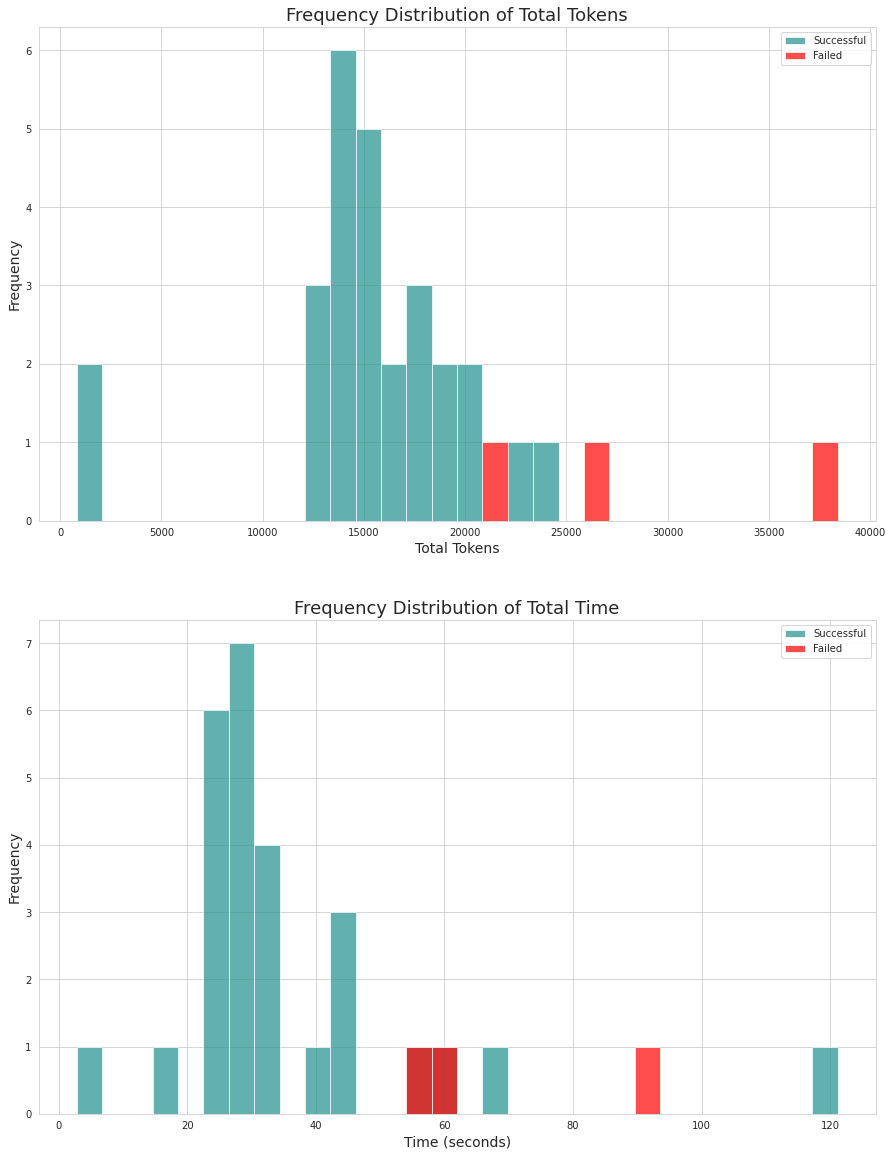

Total number of runs: 30
Number of successful runs: 27
Number of failed runs: 3
Success rate: 90.00%
Failure rate: 10.00%


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your input DataFrame

# Set the style
sns.set_style("whitegrid")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))


# Function to plot histogram with highlighted failures and matched bar widths
def plot_histogram(data, x, ax, title, xlabel):
    # Determine the range and number of bins
    min_val = data[x].min()
    max_val = data[x].max()
    num_bins = 30
    bins = np.linspace(min_val, max_val, num_bins + 1)

    # Plot successful runs
    ax.hist(
        data[data["pass"] == "yes"][x],
        bins=bins,
        alpha=0.7,
        color=sns.color_palette("viridis", as_cmap=True)(0.5),
        label="Successful",
    )

    # Plot failed runs
    ax.hist(
        data[data["pass"] != "yes"][x],
        bins=bins,
        alpha=0.7,
        color="red",
        label="Failed",
    )

    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.legend()


# Plot 1: Frequency Distribution of Total Tokens
plot_histogram(
    df, "total_tokens", ax1, "Frequency Distribution of Total Tokens", "Total Tokens"
)

# Plot 2: Frequency Distribution of Total Latency
plot_histogram(
    df, "latency", ax2, "Frequency Distribution of Total Time", "Time (seconds)"
)

# Adjust layout and display the plot
# plt.tight_layout()
plt.show()

# Print summary statistics
total_runs = len(df)
successful_runs = len(df[df["pass"] == "yes"])
failed_runs = len(df[df["pass"] != "yes"])

print(f"Total number of runs: {total_runs}")
print(f"Number of successful runs: {successful_runs}")
print(f"Number of failed runs: {failed_runs}")
print(f"Success rate: {successful_runs / total_runs * 100:.2f}%")
print(f"Failure rate: {failed_runs / total_runs * 100:.2f}%")

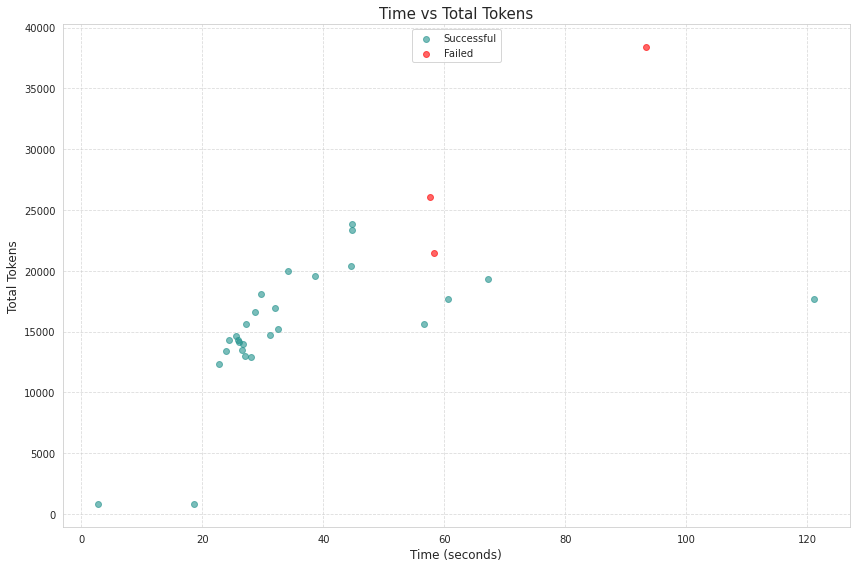

Total number of runs: 30
Number of successful runs: 27
Number of failed runs: 3
Success rate: 90.00%
Failure rate: 10.00%

Averages for successful runs:
Average latency: 36.00 seconds
Average total tokens: 15284.30

Averages for failed runs:
Average latency: 69.79 seconds
Average total tokens: 28654.00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your input DataFrame

# Set the style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(12, 8))

# Create the scatter plot
successful_runs = df[df["pass"] == "yes"]
failed_runs = df[df["pass"] != "yes"]

plt.scatter(
    successful_runs["latency"],
    successful_runs["total_tokens"],
    color=sns.color_palette("viridis", as_cmap=True)(0.5),
    alpha=0.6,
    label="Successful",
)
plt.scatter(
    failed_runs["latency"],
    failed_runs["total_tokens"],
    color="red",
    alpha=0.6,
    label="Failed",
)

# Set labels and title
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Total Tokens", fontsize=12)
plt.title("Time vs Total Tokens", fontsize=15)

# Add legend
plt.legend(fontsize=10, loc="upper center")

# Add grid
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Print summary statistics
total_runs = len(df)
successful_runs_count = len(successful_runs)
failed_runs_count = len(failed_runs)

print(f"Total number of runs: {total_runs}")
print(f"Number of successful runs: {successful_runs_count}")
print(f"Number of failed runs: {failed_runs_count}")
print(f"Success rate: {successful_runs_count / total_runs * 100:.2f}%")
print(f"Failure rate: {failed_runs_count / total_runs * 100:.2f}%")

# Calculate and print averages
print("\nAverages for successful runs:")
print(f"Average latency: {successful_runs['latency'].mean():.2f} seconds")
print(f"Average total tokens: {successful_runs['total_tokens'].mean():.2f}")

print("\nAverages for failed runs:")
print(f"Average latency: {failed_runs['latency'].mean():.2f} seconds")
print(f"Average total tokens: {failed_runs['total_tokens'].mean():.2f}")

## Conclusion

In this walkthrough, you queried LLM runs and loaded associated trace feedback all into a simple tabular format. This makes it easy to export to other analytical tools and data stores.